In [1]:
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [2]:
models = {
#     "GloVe": "baseline",
#     "ConvS2S": "fairseq.wmt14.en-fr.fconv",
#     "InferSent": "infersent.allnli",
#     "IMDB": "imdbsentiment",
#     "skipthought": "skipthought",
#     "DisSent": "dissent.books8.epoch9",
#     "order": "order-embeddings",
#     "ELMo": "elmo.2x4096",
#     "BERT": "bert.base",
# #     "BERT Large": "bert.base-large",
#     "BERT-MRPC": "bert.base.finetune-MRPC",
#     "BERT-CoLA": "bert.base.finetune-CoLA",
#     "BERT-MNLI": "bert.base.finetune-MNLI",
#     "BERT-RTE": "bert.base.finetune-RTE",
#     "BERT-SST": "bert.base.finetune-SST",
#     "BERT-WNLI": "bert.base.finetune-WNLI",
#     "BERT-QQP": "bert.base.finetune-QQP",
#     "BERT-SNLI": "bert.base.finetune-SNLI",
#     "openai": "transformer.roc",
    
    "BERT": "bert.base",
#     "BERT Large": "bert.base-large",
    "BERT-MRPC": "bert.base.finetune-5000-MRPC",
    "BERT-CoLA": "bert.base.finetune-5000-CoLA",
    "BERT-MNLI": "bert.base.finetune-5000-MNLI",
    "BERT-RTE": "bert.base.finetune-5000-RTE",
    "BERT-SST": "bert.base.finetune-5000-SST",
    "BERT-WNLI": "bert.base.finetune-5000-WNLI",
    "BERT-QQP": "bert.base.finetune-5000-QQP",
    "BERT-SNLI": "bert.base.finetune-5000-SNLI",
}

In [3]:
stats = {}

--------

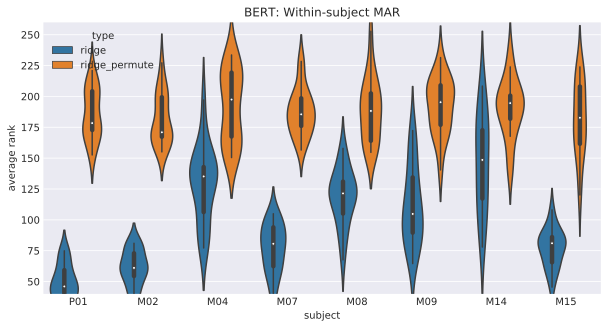

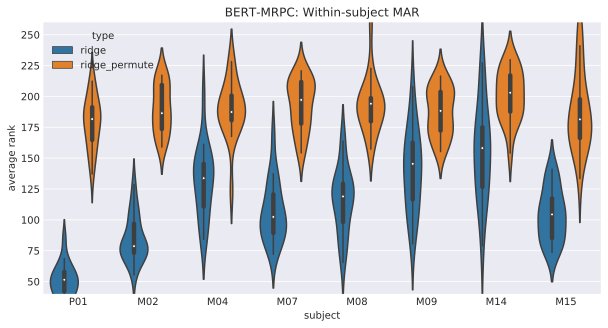

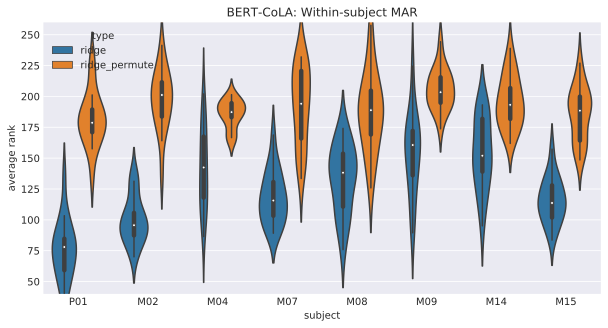

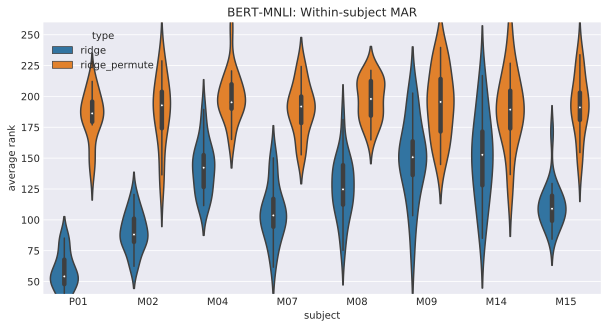

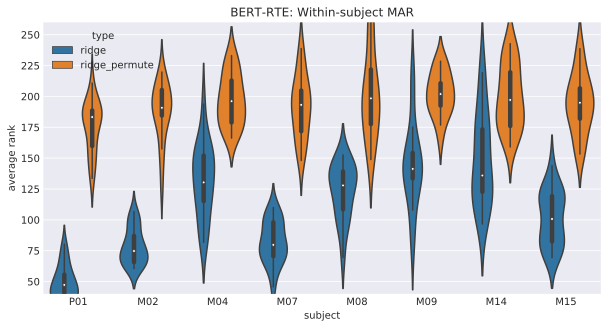

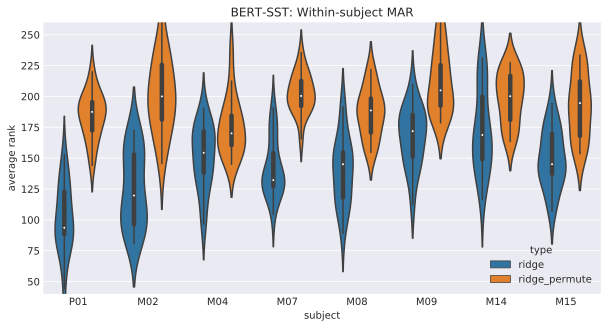

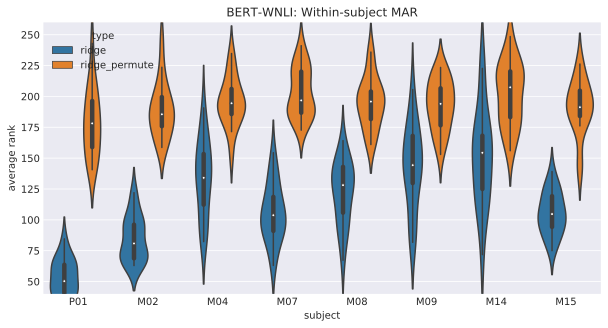

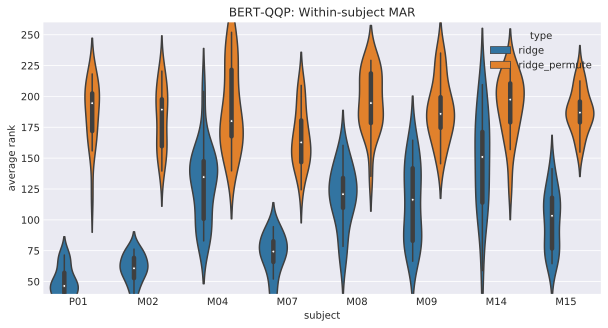

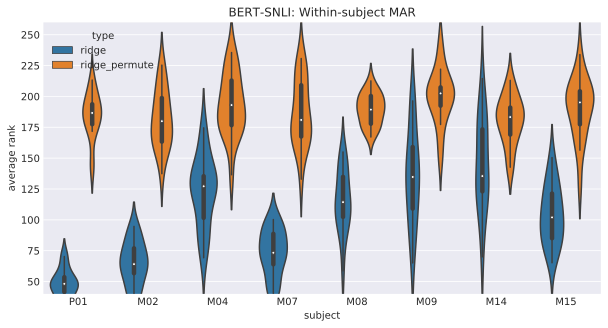

In [4]:
for model, path in models.items():
    f, ax = plt.subplots(figsize=(10,5))
    try:
        stats[model] = util.load_decoding_perf(model, "perf.384sentences.%s.csv" % path, ax=ax)
    except: raise

-----

# Pairwise statistical tests

We'll calculate which model pair differences in performance are significant by the Wilcoxon test on the original sentence-rank data. (The data graphed above are all computed from MAR statistics (meaned across sentences).)

In [5]:
# Aggregate statistics.
f = pd.concat(stats, names=["target", "subject"]).reset_index()

In [6]:
f.head()

type,target,subject,ridge,ridge_permute
0,BERT,P01,48.703704,185.690476
1,BERT,M02,61.005291,181.613757
2,BERT,M04,129.359788,191.584656
3,BERT,M07,76.989418,187.447090
4,BERT,M08,118.492063,189.187831


In [7]:
wilcoxon_results = util.wilcoxon_rank_preds(models)
wilcoxon_results.head()

w_stat          p_val  p_val_corrected
model1 model2                                              
BERT   BERT-MRPC  1552130.5   5.648732e-43     1.569092e-44
       BERT-CoLA  1332364.0   3.676781e-80     1.021328e-81
       BERT-MNLI  1508554.5   5.473344e-51     1.520373e-52
       BERT-RTE   1580731.5   2.241117e-36     6.225326e-38
       BERT-SST   1161078.5  1.626612e-114    4.518366e-116

In [8]:
wilcoxon_results["significant_bonferroni"] = wilcoxon_results["p_val_corrected"] < 0.01
wilcoxon_results.sort_values("p_val")

w_stat          p_val  p_val_corrected  \
model1    model2                                                 
BERT      BERT-SST   1161078.5  1.626612e-114    4.518366e-116   
BERT-SST  BERT-SNLI  1229143.5  6.946765e-101    1.929657e-102   
          BERT-QQP   1225281.5  2.785005e-100    7.736125e-102   
BERT      BERT-CoLA  1332364.0   3.676781e-80     1.021328e-81   
BERT-RTE  BERT-SST   1407264.0   8.907084e-69     2.474190e-70   
BERT-CoLA BERT-QQP   1444245.0   9.956298e-61     2.765638e-62   
BERT-MRPC BERT-SST   1514582.5   3.299847e-52     9.166243e-54   
BERT      BERT-MNLI  1508554.5   5.473344e-51     1.520373e-52   
          BERT-WNLI  1506515.5   3.619594e-50     1.005443e-51   
BERT-SST  BERT-WNLI  1556661.5   2.132755e-49     5.924318e-51   
BERT-CoLA BERT-SNLI  1568677.0   4.925023e-45     1.368062e-46   
BERT-MNLI BERT-QQP   1551044.0   1.032279e-43     2.867442e-45   
BERT      BERT-MRPC  1552130.5   5.648732e-43     1.569092e-44   
          BERT-RTE   1580731.5   2.241117e-36     6.225326e-38   
BERT-MNLI BERT-SST   1665908.0   1.335938e-35     3.710938e-37   
          BERT-SNLI  1626845.0   5.481752e-35     1.522709e-36   
BERT-WNLI BERT-QQP   1654245.5   4.223132e-33     1.173092e-34   
BERT-MRPC BERT-QQP   1679528.5   6.641662e-28     1.844906e-29   
BERT-CoLA BERT-RTE   1723288.5   5.877668e-27     1.632685e-28   
BERT-WNLI BERT-SNLI  1753198.5   2.605395e-22     7.237207e-24   
BERT-RTE  BERT-QQP   1741582.5   2.582868e-20     7.174633e-22   
BERT-MRPC BERT-CoLA  1815087.0   2.772154e-18     7.700428e-20   
          BERT-SNLI  1811144.0   1.456404e-17     4.045566e-19   
BERT-CoLA BERT-SST   1870885.5   6.012594e-16     1.670165e-17   
          BERT-WNLI  1840741.0   2.264286e-15     6.289683e-17   
BERT-MNLI BERT-RTE   1909298.0   3.994416e-11     1.109560e-12   
BERT-RTE  BERT-SNLI  1905274.5   4.550649e-10     1.264069e-11   
BERT-CoLA BERT-MNLI  2014689.0   1.368681e-06     3.801890e-08   
BERT-RTE  BERT-WNLI  1989897.5   2.246247e-05     6.239575e-07   
BERT      BERT-SNLI  2017420.0   1.869518e-04     5.193106e-06   
BERT-MRPC BERT-MNLI  2065553.0   4.380286e-04     1.216746e-05   
BERT-MNLI BERT-WNLI  2070515.0   1.688460e-03     4.690165e-05   
BERT-MRPC BERT-RTE   2048878.0   2.452217e-03     6.811715e-05   
BERT      BERT-QQP   2015533.0   2.507719e-03     6.965886e-05   
BERT-QQP  BERT-SNLI  2097424.5   7.197610e-02     1.999336e-03   
BERT-MRPC BERT-WNLI  2157664.5   3.473799e-01     9.649441e-03   

                     significant_bonferroni  
model1    model2                             
BERT      BERT-SST                     True  
BERT-SST  BERT-SNLI                    True  
          BERT-QQP                     True  
BERT      BERT-CoLA                    True  
BERT-RTE  BERT-SST                     True  
BERT-CoLA BERT-QQP                     True  
BERT-MRPC BERT-SST                     True  
BERT      BERT-MNLI                    True  
          BERT-WNLI                    True  
BERT-SST  BERT-WNLI                    True  
BERT-CoLA BERT-SNLI                    True  
BERT-MNLI BERT-QQP                     True  
BERT      BERT-MRPC                    True  
          BERT-RTE                     True  
BERT-MNLI BERT-SST                     True  
          BERT-SNLI                    True  
BERT-WNLI BERT-QQP                     True  
BERT-MRPC BERT-QQP                     True  
BERT-CoLA BERT-RTE                     True  
BERT-WNLI BERT-SNLI                    True  
BERT-RTE  BERT-QQP                     True  
BERT-MRPC BERT-CoLA                    True  
          BERT-SNLI                    True  
BERT-CoLA BERT-SST                     True  
          BERT-WNLI                    True  
BERT-MNLI BERT-RTE                     True  
BERT-RTE  BERT-SNLI                    True  
BERT-CoLA BERT-MNLI                    True  
BERT-RTE  BERT-WNLI                    True  
BERT      BERT-SNLI                    True  
BERT-MRPC BERT-MNLI                    True

---------

# Aggregate graphs

## Decoding analysis

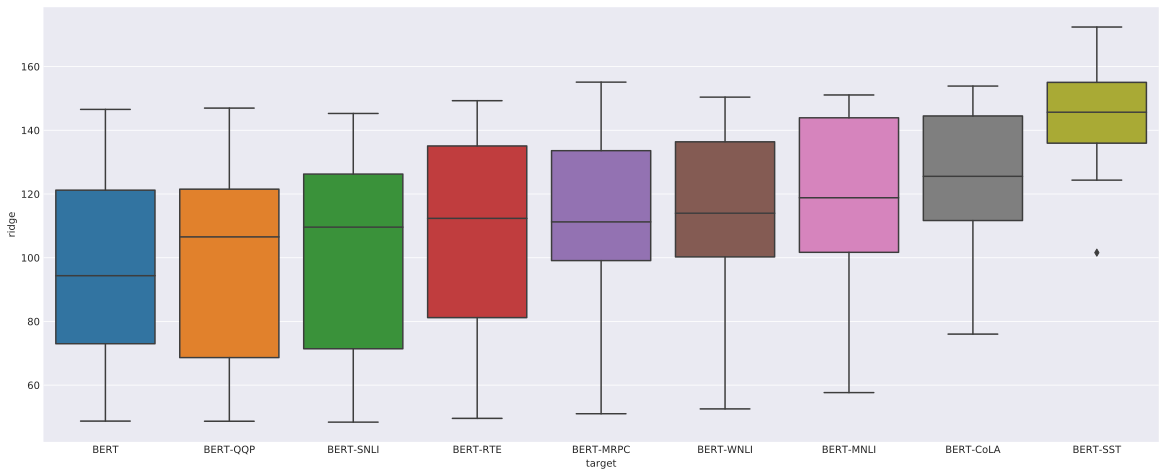

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))

f_sub = f[~f.target.str.endswith("b")]
target_order = f_sub.groupby("target").ridge.agg("mean").argsort()
sns.boxplot(x="target", y="ridge", data=f_sub, ax=ax, order=target_order.index[target_order])

In [10]:
f_sub.groupby("target").ridge.agg("mean")

target
BERT          96.226190
BERT-CoLA    123.954034
BERT-MNLI    116.659061
BERT-MRPC    111.118717
BERT-QQP      98.552249
BERT-RTE     107.514550
BERT-SNLI    101.234458
BERT-SST     143.467593
BERT-WNLI    112.281746
Name: ridge, dtype: float64

[-0.4  0.6  1.6  2.6  3.6  4.6  5.6  6.6  7.6  0. ]


Text(0.87,-0.07,'* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test')

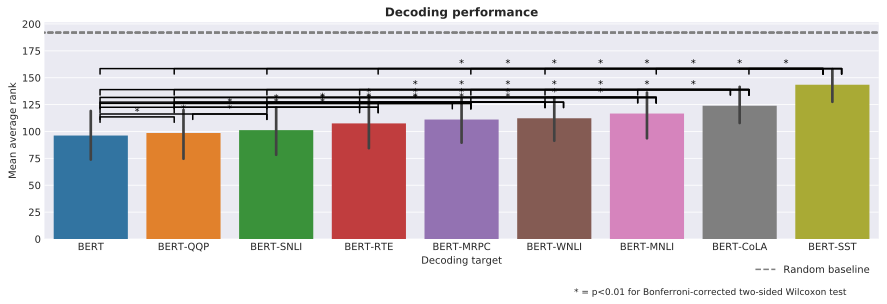

In [12]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x="target", y="ridge", order=target_order.index[target_order], data=f_sub)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.08))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
xticks = {label.get_text(): (pos, label) for pos, label in xticks}
mean_results = f.groupby("target").ridge.agg("mean")
# for (m1_pos, m1_label), (m2_pos, m2_label) in zip(xticks, xticks[1:]):
#     m1_label = m1_label.get_text()
#     m2_label = m2_label.get_text()
for (m1, m2), row in wilcoxon_results.iterrows():
    significant = row.significant_bonferroni
            
    m1_pos, _ = xticks[m1]
    m2_pos, _ = xticks[m2]
    
    if significant:
        y = max(mean_results[m1], mean_results[m2]) + 10
        h = 5
        col = 'k'
        plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)
        
plt.figtext(0.87, -0.07, "* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test", wrap=True, horizontalalignment='right', fontsize=9)

Text(0.5,1,'Decoding performance between subjects')

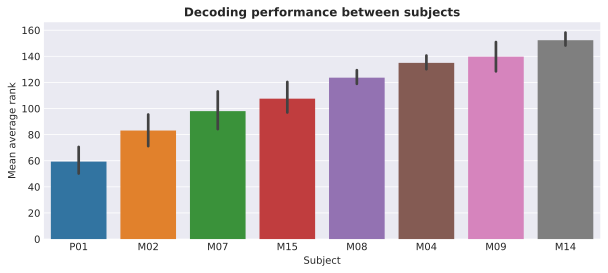

In [13]:
order = f_sub.groupby("subject").ridge.agg("mean").argsort()
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="subject", y="ridge", order=order.index[order], data=f_sub, ax=ax)
plt.xlabel("Subject")
plt.ylabel("Mean average rank")
plt.title("Decoding performance between subjects", weight="bold")